In [1]:
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import uniform,norm,t,binom,expon,chi2,gamma,poisson,beta,dirichlet
from scipy.stats import multivariate_normal as multi_norm
from sklearn.linear_model import LinearRegression as Linear
from scipy.optimize import brentq
from scipy.special import perm,comb
import time
import pandas as pd

**8.1**

In [2]:
def increasing(theta):
    f=lambda x: x**theta
    X=uniform.rvs(size=10000)
    print(np.corrcoef(f(X),f(1-X))[0,1])

In [3]:
increasing(1)
increasing(2)
increasing(4)
increasing(8)
increasing(16)
increasing(32)
increasing(64)
increasing(128)

-1.0
-0.8737886010086059
-0.5358820682108103
-0.2687774831930663
-0.12709154746184836
-0.06641113052402033
-0.03135193830878684
-0.016100091408218817


**8.4**

In [4]:
f=lambda x: 100*(x>0.9)*(x<=0.91)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'<',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

49.213580197499994 < 50.22249447749998
1.0068 0.0099833037497614
0.9923 0.009862083016280079


In [5]:
f=lambda x: 100*(x>0.45)*(x<=0.55)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'>',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

898.5516723899999 > 0.0
9.9819 0.029975851487322257
10.0558 0.04253142100518156


**8.7**

In [6]:
def BB_params(m,s):
    u=np.int64(-1*np.ones(m))
    v=np.int64(-1*np.ones(m))
    a=np.zeros(m)
    b=np.zeros(m)
    w=np.zeros(m)
    for j in range(m):
        sub=s[:j][s[:j]<s[j]]
        u[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.max(sub))
        sub=s[:j][s[:j]>s[j]]
        v[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.min(sub))
        if u[j]>=0 and v[j]>=0:
            l=s[u[j]]
            r=s[v[j]]
            a[j]=(r-s[j])/(r-l)
            b[j]=(s[j]-l)/(r-l)
            w[j]=np.sqrt((s[j]-l)*(r-s[j])/(r-l))
        elif u[j]>=0:
            l=s[u[j]]
            a[j]=1
            w[j]=np.sqrt(s[j]-l)
        elif v[j]>=0:
            r=s[v[j]]
            b[j]=s[j]/r
            w[j]=np.sqrt(s[j]*(r-s[j])/r)
        else:
            w[j]=np.sqrt(s[j])
            
    return u,v,a,b,w

def conBMviaBB(m,s,z,params,Bint):
    u,v,a,b,w=params
    B=np.zeros(m)
    k=len(Bint)
    B[:k]=Bint
    for j in range(k,m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

def BMviaBB(m,s,z,params):
    u,v,a,b,w=params
    B=np.zeros(m)
    for j in range(m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

In [7]:
def straBM(M,N,i,draw):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    if draw:
        plt.plot(np.sort(t),B)
        
    return B

def straGenBM(M,N,i,draw,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    X=delta*np.sort(T*t)+sigma*np.sqrt(T)*B
    if draw:
        plt.plot(np.sort(T*t),X)
        
    return X

def straGBM(M,N,i,draw,S0,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    S=S0*np.exp((delta-sigma**2/2)*np.sort(T*t)+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(np.sort(T*t),S)
        
    return S

def GBM(M,N,draw,S0,delta,sigma,T):
    t=np.linspace(0,1,M+1)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=BMviaBB(M+1,t,Z,params)
    S=S0*np.exp((delta-sigma**2/2)*T*t+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(T*t,S)
        
    return S

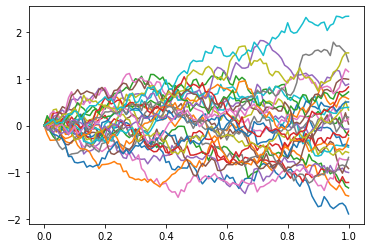

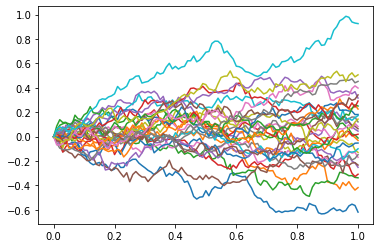

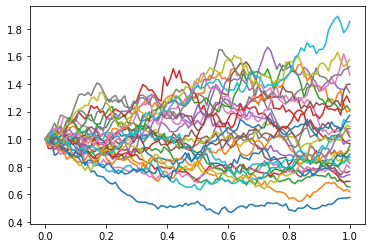

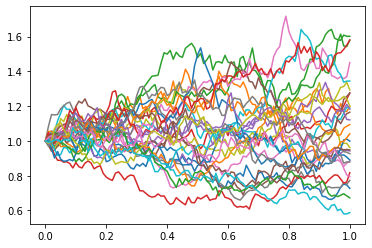

In [8]:
M=100
N=30
draw=True
for i in range(N):
    straBM(M,N,i+1,draw)
    
plt.show()

delta=0.05
sigma=0.3
T=1
for i in range(N):
    straGenBM(M,N,i+1,draw,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    GBM(M,N,draw,S0,delta,sigma,T)
    
plt.show()

In [9]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.4590096496162972 0.004357458558876558
6.143303871154785


In [10]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.46508169406264466 0.004552540166206431
3.8307411670684814


**8.9**

In [11]:
g=lambda x: np.sqrt(5/4+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.827830845186201 0.5771830081939697
1.827560513968501 0.6789970397949219
0.5521622277661995 0.1272810338527621 5.103373374651348


In [12]:
g=lambda x: np.sqrt(1+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.682120644340217 0.5396749973297119
1.6824884273319514 0.6495537757873535
0.4674460921866036 0.15179717669264794 3.7063860527791115


**8.10**

In [13]:
df=pd.read_csv('data/ch8.8.10.csv')
data=df.values
print(data.shape)
num=data[:,0]
alpha1=data[:,1]+1
alpha2=data[:,2]+1

(38, 3)


In [14]:
def roulette(num,alpha,wheel,size):
    def h(x):
        y=np.ones_like(x)*1.0
        for a in alpha[num!=wheel]:
            y*=gamma.cdf(x,a=a)

        return y

    X=gamma.rvs(size=size,a=alpha[num==wheel])
    print('conditional:')
    print(np.mean(h(X)),np.std(h(X))/np.sqrt(size))
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==S.max(axis=1)
    print('normal:')
    print(np.mean(S1),np.std(S1)/np.sqrt(size))
    S2=S[:,num==wheel].flatten()/S.sum(axis=1)
    print('probability:')
    print(np.mean(S2),np.std(S2)/np.sqrt(size))
    print('alpha:')
    print(alpha[num==wheel]/np.sum(alpha))

In [15]:
size=100000
roulette(num,alpha1,19,size)
print()
roulette(num,alpha2,3,size)
print()
roulette(num,alpha1,36,size)

conditional:
0.6297796746590201 0.0010930013735310172
normal:
0.63073 0.001526137828310405
probability:
0.02862245194250263 1.872270615104299e-06
alpha:
[0.02862046]

conditional:
0.738485223792369 0.0009154408952097517
normal:
0.7375 0.0013913797109344377
probability:
0.0295802782385485 2.421977058562679e-06
alpha:
[0.02958105]

conditional:
0.10717738634202936 0.0006090609066813694
normal:
0.10514 0.0009699772182891719
probability:
0.027829926139778926 1.8379981074651475e-06
alpha:
[0.02783136]


**8.11**

In [16]:
def roulette(num,alpha,wheel,size):
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==np.sort(S,axis=1)[:,-2]
    print(np.mean(S1),np.std(S1)/np.sqrt(size))

In [17]:
roulette(num,alpha1,19,10000)

0.172 0.003773804446443933


**8.14**

In [18]:
def roulette(A,size):
    num=data[:,0]
    alpha1=data[:,1]+A
    alpha2=data[:,2]+A
    def h(x,alpha,wheel):
        y=np.ones_like(x)*1.0
        for a in alpha[num!=wheel]:
            y*=gamma.cdf(x,a=a)

        return y

    X1=gamma.rvs(size=size,a=alpha1[num==19])
    Y1=h(X1,alpha1,19)
    X2=gamma.rvs(size=size,a=alpha2[num==3])
    Y2=h(X2,alpha2,3)
    print(np.mean(Y1),np.mean(Y2))

In [19]:
roulette(1,100000)
roulette(100,100000)
roulette(10000,100000)
roulette(1000000,100000)
roulette(100000000,100000)
roulette(10000000000,100000)
print()
print(1/38)

0.6291018640622289 0.7396639865588199
0.6163773704139436 0.7216068713273408
0.2343453311739279 0.22725178009742286
0.03875235888844526 0.037669008085453246
0.027882275577168717 0.02767889556938128
0.025798395182948717 0.026480476838276343

0.02631578947368421


**8.16**

In [20]:
f=lambda x: x**(-0.5)+x
h=lambda x: x**(-0.5)
mu=5/2
theta=2
size=50
R=10000
Beta=np.zeros(R)
Mu0=np.zeros(R)
Mu1=np.zeros(R)
Mu2=np.zeros(R)
for i in range(R):
    X=uniform.rvs(size=size)
    x=(h(X)-theta).reshape(-1, 1)
    y=f(X)
    reg=Linear().fit(x,y)
    Beta[i]=reg.coef_[0]
    x=x.flatten()
    Mu0[i]=np.mean(y-Beta[i]*x)
    Mu1[i]=np.mean(y-x)
    Mu2[i]=np.mean(y-2*x)

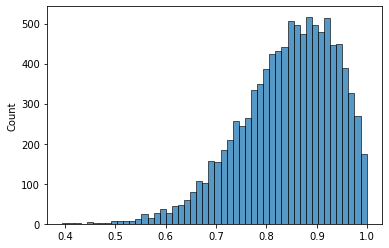

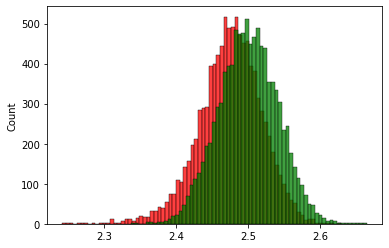

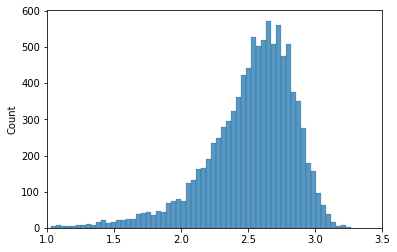

In [21]:
sb.histplot(Beta)
plt.show()
sb.histplot(Mu0,color='r')
sb.histplot(Mu1,color='g')
plt.show()
sb.histplot(Mu2)
plt.xlim([1,3.5])
plt.show()

**8.22**

In [208]:
def M(x):
    if x<98.5:
        return 98.5
    elif x>101.5:
        return 101.5
    else:
        return x

Mp=lambda x: 100

def test(X,M):
    X10=X[0:10]
    x1=np.mean(X10)
    s1=np.sqrt(np.sum((X10-x1)**2)/9)
    if np.abs(x1-M(x1))+2.4*s1<=15:
        return True,False
    else:
        x2=np.mean(X)
        s2=np.sqrt(np.sum((X-x2)**2)/29)
        M2=M(x2)
        if np.abs(x2-M2)+2.0*s2<=15 and X.min()>=0.75*M2 and X.max()<=1.25*M2:
            return True,True
        else:
            return False,True

In [209]:
N=1000
Uset=norm.rvs(size=30*N).reshape([N,30])
n=10
Mu=np.linspace(80,120,4*n)
Sigma=np.linspace(0,15,2*n)
Pset=np.zeros([2*n,4*n])
Ppset=np.zeros([2*n,4*n])

for i,sigma in enumerate(Sigma):
    for j,mu in enumerate(Mu):
        P=np.zeros(N)
        Pp=np.zeros(N)
        for k,X in enumerate(mu+sigma*Uset):
            P[k]=test(X,M)[0]
            Pp[k]=test(X,Mp)[0]
            
        Pset[i,j]=np.mean(P)
        Ppset[i,j]=np.mean(Pp)

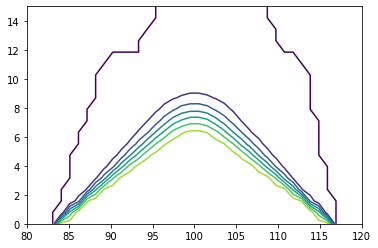

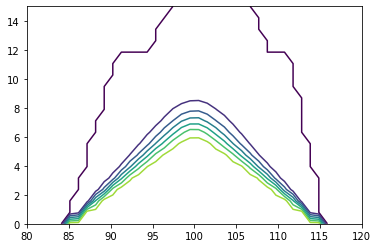

0.0
1.0
[ 84.1025641 115.8974359] [0. 0.]


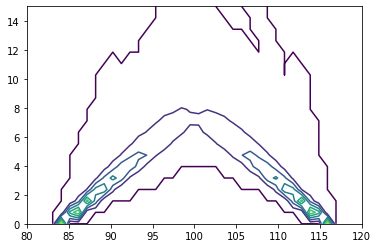

In [210]:
X,Y=np.meshgrid(Mu,Sigma)
plt.contour(X,Y,Pset);
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
plt.show()
plt.contour(X,Y,Ppset);
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
plt.show()
print(np.min(Pset-Ppset))
print(np.max(Pset-Ppset))
print(X[Pset-Ppset==np.max(Pset-Ppset)],Y[Pset-Ppset==np.max(Pset-Ppset)])
plt.contour(X,Y,Pset-Ppset);
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
plt.show()

**8.23**

In [217]:
N=1000
Uset=norm.rvs(size=30*N).reshape([N,30])
n=10
Mu=np.linspace(80,120,4*n)
Sigma=np.linspace(0,15,2*n)
P2set=np.zeros([2*n,4*n])
Pset=np.zeros([2*n,4*n])

for i,sigma in enumerate(Sigma):
    for j,mu in enumerate(Mu):
        P2=np.zeros(N)
        P=np.zeros(N)
        for k,X in enumerate(mu+sigma*Uset):
            tmp=test(X,M)
            P2[k]=tmp[1]
            P[k]=np.prod(tmp)
            
        P2set[i,j]=np.mean(P2)
        Pset[i,j]=np.mean(P)

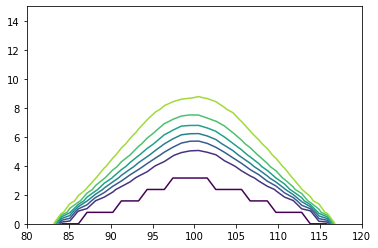

0.422
[101.53846154] [6.31578947]


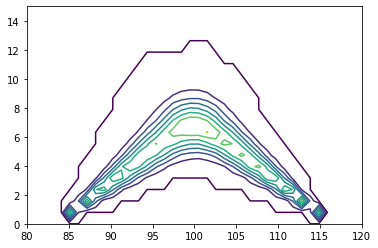

In [218]:
X,Y=np.meshgrid(Mu,Sigma)
plt.contour(X,Y,P2set);
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
plt.show()
print(np.max(Pset))
print(X[Pset==np.max(Pset)],Y[Pset==np.max(Pset)])
plt.contour(X,Y,Pset);
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
plt.show()

**8.25**